In [25]:
import pandas as pd
import numpy as np
from scipy import stats
choice_data =np.load('clean_data.npy')
num_subjects=len(choice_data)
print(choice_data.shape)
print(num_subjects)

(19, 5, 15)
19


In [42]:
from pystan import StanModel


model_input='''
data {

    int<lower=1> Ntrials;
    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int<lower=0,upper=1> Choice[NxSubjects, NxConditions, Ntrials];
}

parameters {   
  
    vector[NxSubjects] aW1_raw;
    vector[NxSubjects] aW2_raw;
    vector[NxSubjects] aW3_raw;
    vector[NxSubjects] aW4_raw;
    vector[NxSubjects] aW5_raw;
    vector<lower=-10,upper=10>[NxSubjects] aS;

  //Group level Prior variance
  real<lower=0.01,upper=20> sigma1;
  real<lower=0.01,upper=20> sigma2;
  real<lower=0.01,upper=20> sigma3;
  real<lower=0.01,upper=20> sigma4;
  real<lower=0.01,upper=20> sigma5;

  real mu1;
  real mu2;
  real mu3;
  real mu4;
  real mu5;

}

transformed parameters {

vector<lower=0,upper=1>[NxSubjects] theta_neutral;
vector<lower=0,upper=1>[NxSubjects] theta_cp;
vector<lower=0,upper=1>[NxSubjects] theta_ct;
vector<lower=0,upper=1>[NxSubjects] theta_rp;
vector<lower=0,upper=1>[NxSubjects] theta_rt;

vector[NxSubjects] aW1;
vector[NxSubjects] aW2;
vector[NxSubjects] aW3;
vector[NxSubjects] aW4;
vector[NxSubjects] aW5;

// Non-Centered Parameterization

aW1 = mu1 + sigma1 * aW1_raw;
aW2 = mu2 + sigma2 * aW2_raw;
aW3 = mu3 + sigma3 * aW3_raw;
aW4 = mu4 + sigma4 * aW4_raw;
aW5 = mu5 + sigma5 * aW5_raw;

for (k in 1:NxSubjects){

        theta_neutral[k] = inv_logit(aW1[k]+aS[k]);
        theta_cp[k] = inv_logit(aW2[k]+aS[k]);
        theta_ct[k] = inv_logit(aW3[k]+aS[k]);
        theta_rp[k] = inv_logit(aW4[k]+aS[k]);
        theta_rt[k] = inv_logit(aW5[k]+aS[k]);
    }
}
model {
    
    sigma1 ~ uniform(0.01,20);
    sigma2 ~ uniform(0.01,20);
    sigma3 ~ uniform(0.01,20);
    sigma4 ~ uniform(0.01,20);
    sigma5 ~ uniform(0.01,20);
    
    mu1 ~ normal(0,5);
    mu2 ~ normal(0,5);
    mu3 ~ normal(0,5);
    mu4 ~ normal(0,5);
    mu5 ~ normal(0,5);
    
    aS ~ uniform(-10,10);
    aW1 ~ normal(mu1,sigma1);
    aW2 ~ normal(mu2,sigma2);
    aW3 ~ normal(mu3,sigma3);
    aW4 ~ normal(mu4,sigma4);
    aW5 ~ normal(mu5,sigma5);
    
    aW1 ~ std_normal();
    aW2 ~ std_normal();
    aW3 ~ std_normal();
    aW4 ~ std_normal();
    aW5 ~ std_normal();
    

    for (k in 1:NxSubjects){
                
    
            // Neutral condition choices
            Choice[k,1,:] ~ bernoulli(theta_neutral[k]);

            // Positive-common choices
            Choice[k,2,:] ~ bernoulli(theta_cp[k]);

            // Threat-common choices
            Choice[k,3,:] ~ bernoulli(theta_ct[k]); 
    
            // Positive-rare choices
            Choice[k,4,:] ~ bernoulli(theta_rp[k]);
            
            // Threat-rare choices
            Choice[k,5,:] ~ bernoulli(theta_rt[k]);

        
      }
    }
    
'''
data_input = {
              'Ntrials': 15, # trials per condition
              'Choice':choice_data,#choice data
              'NxConditions':5,
              'NxSubjects':num_subjects
                    }

controls={'adapt_delta':0.9,
         'max_treedepth':18}

model_fit = StanModel(model_code=model_input)
fit_RE_A = model_fit.sampling(data=data_input,iter=4000,control=controls)
print(fit_RE_A)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0931809100cb7476bb62d511dde8343f NOW.


Inference for Stan model: anon_model_0931809100cb7476bb62d511dde8343f.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

                     mean se_mean     sd   2.5%    25%     50%    75%  97.5%  n_eff   Rhat
aW1_raw[1]        -1.9e-3  6.8e-3   0.99  -1.97  -0.67  3.6e-3   0.67   1.94  21244    1.0
aW1_raw[2]          -0.03  7.1e-3   1.02  -1.99  -0.72   -0.03   0.65   1.98  20487    1.0
aW1_raw[3]           0.04  6.9e-3    1.0  -1.94  -0.63    0.04   0.72    2.0  20755    1.0
aW1_raw[4]           0.02  6.7e-3   1.02  -1.93  -0.67    0.02   0.72   1.99  23058    1.0
aW1_raw[5]          -0.04  7.3e-3   1.02  -2.03  -0.72   -0.05   0.65   1.97  19582    1.0
aW1_raw[6]           0.02  7.0e-3   0.99  -1.93  -0.63    0.02   0.68    2.0  19831    1.0
aW1_raw[7]          -0.01  6.9e-3   0.99  -1.94  -0.68 -4.1e-3   0.65   1.91  20503    1.0
aW1_raw[8]          -0.01  7.2e-3    1.0  -1.98  -0.69   -0.01   0.67   1.89  19387

h N-common: 0.45745775769676844
h N-emotion : 0.9525324187878916


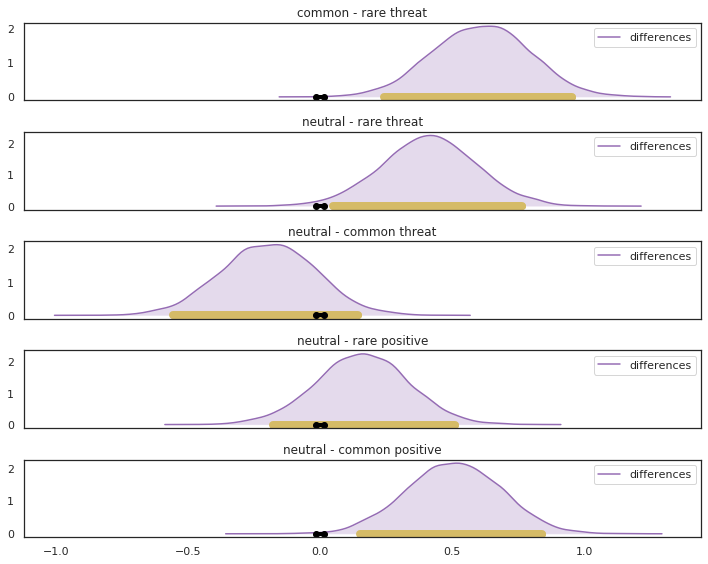

low end diff ct rt 0.24063881536505013


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from bayesian_bootstrap.bootstrap import mean, highest_density_interval
import pandas as pd

# import pickle
# with open("ANOVA_r2_model_fit.pkl", "wb") as f:
#     pickle.dump({'model' : model_input, 'fit' : fit}, f, protocol=-1)


fit_df_2 = fit_RE_A.to_dataframe()
#fit_df_2.to_csv('../../raw_data/fullRE_cauchy.csv')
#fit_df_2 = pd.read_csv('../../raw_data/fullRE_cauchy.csv')
#Extract data
chain_idx = fit_df_2['draw']
neutral = fit_df_2['mu1']
common_p = fit_df_2['mu2']
common_t = fit_df_2['mu3']
rare_p = fit_df_2['mu4']
rare_t = fit_df_2['mu5']



#Compute Contrasts
diff_v = rare_p-rare_t
rares=((rare_p+rare_t)/2.0)
commons=((common_p+common_t)/2.0)
diff_type=rares-commons
diff_rare=neutral-rares
diff_common=neutral-commons
diff_emotion=common_t-rare_t
diff_n=neutral-rare_t
diff_c=neutral-common_t
diff_rp=neutral-rare_p
diff_cp=neutral-common_p

#Compute HDIs
l_ct, r_ct = highest_density_interval(common_t)
l_cp, r_cp = highest_density_interval(common_p)
l_rp, r_rp = highest_density_interval(rare_p)
l_rt,r_rt=highest_density_interval(rare_t)
l_n,r_n=highest_density_interval(neutral)
le,re=highest_density_interval(diff_common)
lx,rx=highest_density_interval(diff_emotion)
l,r=highest_density_interval(diff_n)
lc,rc=highest_density_interval(diff_c)
lp,rp=highest_density_interval(diff_rp)
lcp,rcp=highest_density_interval(diff_cp)

#lg,hg=highest_density_interval(diff_lrs)
print('h N-common: {}'.format(re))
print('h N-emotion : {}'.format(rx))


rope_val=0.015


sns.set(style="white",
        palette="muted",
        color_codes=True)

f, axs = plt.subplots(5, 1, figsize=(10,8),sharex=True)


# ax0=sns.distplot(rare_t, hist=False,kde_kws={"shade": True},color="k", ax=axs[0])
# ax0.set(title='Rares_Threats',xlabel='')

# axs[0].plot([l_rt, r_rt],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[0].plot([-rope_val,rope_val ],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


# ax1=sns.distplot(rare_p, hist=False,kde_kws={"shade": True},color="g", ax=axs[1])
# ax1.set(title='Rares_positive',xlabel='')

# axd=sns.distplot(diff_v, hist=False,kde_kws={"shade": True},color="m", ax=axs[2])
# axd.set(title='rare positive vs. rare negative',xlabel='')


# ax2=sns.distplot(common_p, hist=False, kde_kws={"shade": True},color="b", ax=axs[3])
# ax2.set(title='Commons_Positive',xlabel='')

# axct=sns.distplot(common_t, hist=False, kde_kws={"shade": True},color="b", ax=axs[4])
# axct.set(title='Commons_Threat',xlabel='')

# axv=sns.distplot(diff_type, hist=False, kde_kws={"shade": True},color="m", ax=axs[5],label='P vs N')
# axv.set(title='Emotion w/ rare transitions vs. Emotion w/ common transitions',xlabel='')



# axn=sns.distplot(neutral, hist=False, kde_kws={"shade": True},color="y", ax=axs[6])
# axn.set(title='neutral',xlabel='')


ax3=sns.distplot(diff_emotion, hist=False, kde_kws={"shade": True},color="m", ax=axs[0],label='differences')
ax3.set(title='common - rare threat',xlabel='')

axs[0].plot([lx, rx],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[0].plot([-rope_val,rope_val ],[0,0],linewidth=4.0,label='ROPE',marker='o',color='black')

ax3=sns.distplot(diff_n, hist=False, kde_kws={"shade": True},color="m", ax=axs[1],label='differences')
ax3.set(title='neutral - rare threat',xlabel='')

axs[1].plot([l, r],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[1].plot([-rope_val,rope_val ],[0,0],linewidth=4.0,label='ROPE',marker='o',color='black')


ax3=sns.distplot(diff_c, hist=False, kde_kws={"shade": True},color="m", ax=axs[2],label='differences')
ax3.set(title='neutral - common threat',xlabel='')

axs[2].plot([lc, rc],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[2].plot([-rope_val,rope_val ],[0,0],linewidth=4.0,label='ROPE',marker='o',color='black')

ax3=sns.distplot(diff_rp, hist=False, kde_kws={"shade": True},color="m", ax=axs[3],label='differences')
ax3.set(title='neutral - rare positive',xlabel='')

axs[3].plot([lp, rp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[3].plot([-rope_val,rope_val ],[0,0],linewidth=4.0,label='ROPE',marker='o',color='black')

ax3=sns.distplot(diff_cp, hist=False, kde_kws={"shade": True},color="m", ax=axs[4],label='differences')
ax3.set(title='neutral - common positive',xlabel='')

axs[4].plot([lcp, rcp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[4].plot([-rope_val,rope_val ],[0,0],linewidth=4.0,label='ROPE',marker='o',color='black')

plt.tight_layout()
plt.show()

print('low end diff ct rt {}'.format(lx))


In [58]:
from pystan import StanModel


model_input='''
data {

    int<lower=1> Ntrials;
    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int Choice[NxSubjects, NxConditions, Ntrials];
}

parameters {   
  // Grand mean
  real a0;
  
  //Conditions
  vector[NxConditions] aW;
  vector[NxSubjects] aS;
  
  //Group level Prior variance
  real<lower=0> sigma_subject;
  real<lower=0> sigma_condition;
  
    
}

transformed parameters {

vector[NxSubjects] theta_neutral;
vector[NxSubjects] theta_cp;
vector[NxSubjects] theta_ct;
vector[NxSubjects] theta_rp;
vector[NxSubjects] theta_rt;


// Translate to sum-to-zero deflections away from Grand Mean 
real b0;
vector[NxConditions] bConditions;
vector[NxSubjects] bSubjects;

    

// Mean predicted values (before logistic transform) per conditionXsubject cell

matrix[NxConditions,NxSubjects] m;

  // Convert parameters to sum-to-zero
  
  for ( u in 1:NxConditions){
      for ( b in 1: NxSubjects){
          m[u,b] = a0+aW[u]+aS[b];
      }
  }
  // Grand mean (mean over matrix of all cells)
  b0 = mean(m);
  
  //Effects of Condition (how average effect across subjects is different from Grand Mean)
  for (j in 1:NxConditions){bConditions[j]=mean(m[j,1:NxSubjects])-b0;}
  
  //Effects of Subject
  for (h in 1:NxSubjects){bSubjects[h]=mean(m[1:NxConditions,h])-b0;}



for (k in 1:NxSubjects){
        theta_neutral[k] = inv_logit(a0+aW[1]+aS[k]);
        theta_cp[k] = inv_logit(a0+aW[2]+aS[k]);
        theta_ct[k] = inv_logit(a0+aW[3]+aS[k]);
        theta_rp[k] = inv_logit(a0+aW[4]+aS[k]);
        theta_rt[k] = inv_logit(a0+aW[5]+aS[k]);
    }
}
model {

    sigma_subject ~ uniform(0,10);
    sigma_condition ~ uniform(0,10);
    
    
    a0 ~ normal(0,10);
    aS ~ normal(0,sigma_subject);
    aW ~ normal(0,sigma_condition);
    
    
    for (k in 1:NxSubjects){
                
    
            // Neutral condition choices
            Choice[k,1,:] ~ bernoulli(theta_neutral[k]);

            // Positive-common choices
            Choice[k,2,:] ~ bernoulli(theta_cp[k]);

            // Threat-common choices
            Choice[k,3,:] ~ bernoulli(theta_ct[k]); 
            
            // Positive-rare choices
            Choice[k,4,:] ~ bernoulli(theta_rp[k]);
            
            // Threat-rare choices
            Choice[k,5,:] ~ bernoulli(theta_rt[k]);
            
            
        
            
              
      }
    }
    
'''
data_input = {
              'Ntrials': 15, # trials per condition
              'Choice':choice_data,#choice data
              'NxConditions':5,
              'NxSubjects':num_subjects
                    }

controls={'adapt_delta':0.9,
         'max_treedepth':18}

model_fit = StanModel(model_code=model_input)
fit_fe = model_fit.sampling(data=data_input,iter=4000,control=controls)
print(fit_fe)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ee5d12e7c80b23c4c922117b21618cf4 NOW.


Inference for Stan model: anon_model_ee5d12e7c80b23c4c922117b21618cf4.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0                  1.05    0.02   0.54   0.01   0.71   1.04   1.38   2.13    758    1.0
aW[1]               0.22 10.0e-3   0.34  -0.45   0.05   0.22    0.4   0.92   1187    1.0
aW[2]              -0.41 10.0e-3   0.34  -1.14  -0.59   -0.4  -0.22   0.21   1164    1.0
aW[3]               0.47    0.01   0.34  -0.19   0.29   0.46   0.65   1.17   1173    1.0
aW[4]               0.02    0.01   0.34  -0.65  -0.15   0.03    0.2   0.68   1129    1.0
aW[5]               -0.3    0.01   0.34  -1.02  -0.47  -0.29  -0.11   0.33   1115    1.0
aS[1]               1.81    0.02   0.63   0.63   1.39    1.8   2.22   3.08   1477    1.0
aS[2]              -1.73    0.02   0.49   -2.7  -2.06  -1.73   -1.4  -0.78    953    1.0
aS[3]     

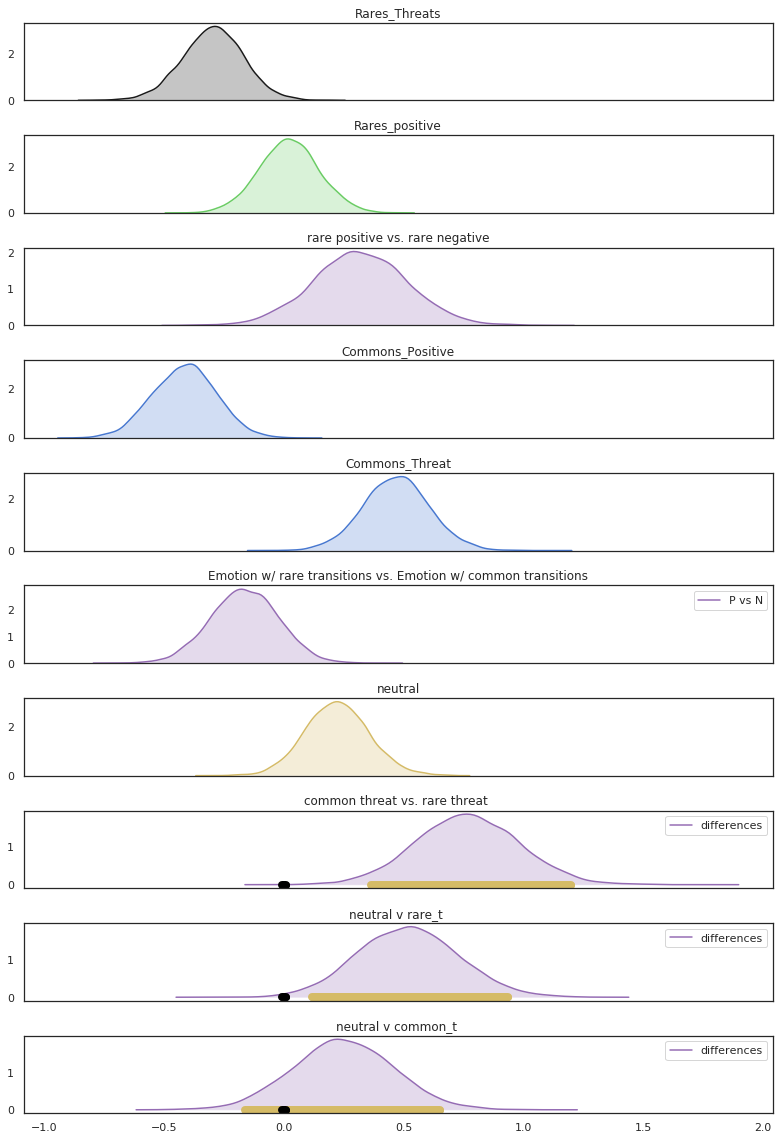

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from bayesian_bootstrap.bootstrap import mean, highest_density_interval
import pandas as pd

# import pickle
# with open("ANOVA_r2_model_fit.pkl", "wb") as f:
#     pickle.dump({'model' : model_input, 'fit' : fit}, f, protocol=-1)


fit_df_2 = fit_fe.to_dataframe()
#fit_df_2.to_csv('Bayesian_r2_RandomEffects.csv')
#fit_df=pd.read_csv('Bayesian_rmANOVA_output_r2_removedOutlier_groupPriorSDs_noInteraction_covaryingValueatChoice.csv')
#Extract data
chain_idx = fit_df_2['draw']
neutral = fit_df_2['bConditions[{}]'.format(1)]
common_p = fit_df_2['bConditions[{}]'.format(2)]
common_t = fit_df_2['bConditions[{}]'.format(3)]
rare_p = fit_df_2['bConditions[{}]'.format(4)]
rare_t = fit_df_2['bConditions[{}]'.format(5)]

diff_v = rare_p-rare_t
rares=((rare_p+rare_t)/2.0)
commons=((common_p+common_t)/2.0)
diff_type=rares-commons
diff_rare=neutral-rares
diff_common=neutral-commons
diff_raret=common_t-rare_t
diff_n=neutral-rare_t
d_c=common_t-neutral


#Compute HDIs
l_ct, r_ct = highest_density_interval(common_t)
l_cp, r_cp = highest_density_interval(common_p)
l_rp, r_rp = highest_density_interval(rare_p)
l_rt,r_rt=highest_density_interval(rare_t)
l_n,r_n=highest_density_interval(neutral)
le,re=highest_density_interval(diff_raret)
l,r=highest_density_interval(diff_n)
nm,mm=highest_density_interval(d_c)

rope_val=0.01


sns.set(style="white",
        palette="muted",
        color_codes=True)

f, axs = plt.subplots(10, 1, figsize=(11, 16),sharex=True)
# for ax in range(len(axs)):
#     if ax<6:
#         axs[ax].axvline(0,0,lw=2.0,ls='--',color='k')
#         axs[ax].text(-0.05,-0.5,'0',rotation=0)
#         axs[ax].axvline(-2.41,0,lw=2.0,ls='--',color='k')
#         axs[ax].text(-2.5,-1,'Chance',rotation=0)
#     elif ax==6:
#         axs[ax].axvline(0,0,lw=2.0,ls='--',color='k')
#         axs[ax].text(-0.05,-0.8,'0',rotation=0)

ax0=sns.distplot(rare_t, hist=False,kde_kws={"shade": True},color="k", ax=axs[0])
ax0.set(title='Rares_Threats',xlabel='')

ax1=sns.distplot(rare_p, hist=False,kde_kws={"shade": True},color="g", ax=axs[1])
ax1.set(title='Rares_positive',xlabel='')

axd=sns.distplot(diff_v, hist=False,kde_kws={"shade": True},color="m", ax=axs[2])
axd.set(title='rare positive vs. rare negative',xlabel='')

# axs[2].plot([lv, rv],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[2].plot([-.016, .016],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


ax2=sns.distplot(common_p, hist=False, kde_kws={"shade": True},color="b", ax=axs[3])
ax2.set(title='Commons_Positive',xlabel='')

axct=sns.distplot(common_t, hist=False, kde_kws={"shade": True},color="b", ax=axs[4])
axct.set(title='Commons_Threat',xlabel='')

axv=sns.distplot(diff_type, hist=False, kde_kws={"shade": True},color="m", ax=axs[5],label='P vs N')
axv.set(title='Emotion w/ rare transitions vs. Emotion w/ common transitions',xlabel='')

# axs[4].plot([lt, rt],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[4].plot([-.002, .002],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

axn=sns.distplot(neutral, hist=False, kde_kws={"shade": True},color="y", ax=axs[6])
axn.set(title='neutral',xlabel='')


# axs[7].plot([l, r],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
# axs[7].plot([-.016, .016],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


ax4=sns.distplot(diff_raret, hist=False, kde_kws={"shade": True},color="m", ax=axs[7],label='differences')
ax4.set(title='common threat vs. rare threat ',xlabel='')

axs[7].plot([le, re],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[7].plot([-rope_val,rope_val],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


ax4=sns.distplot(diff_n, hist=False, kde_kws={"shade": True},color="m", ax=axs[8],label='differences')
ax4.set(title='neutral v rare_t ',xlabel='')

axs[8].plot([l, r],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[8].plot([-rope_val,rope_val],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


ax4=sns.distplot(d_c, hist=False, kde_kws={"shade": True},color="m", ax=axs[9],label='differences')
ax4.set(title='neutral v common_t ',xlabel='')

axs[9].plot([nm, mm],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[9].plot([-rope_val,rope_val],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')





plt.tight_layout()
plt.show()
